__File: src_2021_workshop_fig.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     Mar 17, 2021__

Generating some figures for Scott's talk in the JLab SRC EMC workshop. Also use this for testing SRC functions and related things.

__Revision history:<br/>__
* Mar 18, 2021 - Created the following plotting functions: n_lambda_deuteron_decomposition, deuteron_3S1_3D1_ratios, factorization_ratios, srg_transformation_ratios_fixed_k, and pp_pn_ratios.
* Mar 22, 2021 - Created high_q_momentum_distributions. Also added $a_2$ scaling factors function.
* Mar 23, 2021 - Created p_n_ratios and finalized a2_scaling_factors.
* Mar 29, 2021 - Added cells at the bottom for testing purposes.
* Mar 30, 2021 - Moved single-nucleon momentum distributions data to Figures/SRC_physics/Momentum_distribution_data for faster plotting.
* Apr 01, 2021 - Including $P$-waves in figures involving pair momentum distributions.
* Apr 06, 2021 - Created partial_wave_ratios and contact_ratios. Updated n_lambda_deuteron_decomposition and deuteron_3S1_3D1_ratios with changes to dmd.py and pmd_deuteron_test.py.

In [1]:
from os import chdir, getcwd
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time
# Scripts made by A.T.
from dmd import deuteron_momentum_distributions
from Figures import figures_functions as ff
from lda import load_density, LDA
import observables as ob
import operators as op
from pmd import pair_momentum_distributions
from Potentials.vsrg_macos import vnn
from snmd import single_nucleon_momentum_distributions
from SRG.srg_unitary_transformation import SRG_unitary_transformation

In [2]:
# Current working directory
cwd = getcwd()

__Decomposition of $n^{\lambda}_d(q)$__

In [3]:
def n_lambda_deuteron_decomposition(kvnn, lamb, kmax=0, kmid=0, ntot=0, curves=4, xlim=(0, 4), ylim=(1e-5, 1e3)):
    """
    Plots the SRG-evolved deuteron pair momentum distribution as calculated by our expansion of U(k, k') in
    second quantization. Shows each of the contributions from 1, \delta U, \delta U \delta U^\dagger.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1]. Will use potential's default value if no argument is
        entered.
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1]. Will use potential's default value if no argument is
        entered.
    ntot : int, optional
        Number of momentum points in mesh. Will use potential's default value if no argument is entered.
    curves : int
        Number of curves to be plotted starting with the full high-resolution result, then the 1 term, \delta U,
        term, and finally \delta U \delta U^{\dagger} term.
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [fm^3]. If ylim[0] <= 0, plots on a linear y-scale.
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """


    # --- Set up --- #
    
    # Make sure the number of curves makes sense
    # Can only go from 1 to 4
    if not ( curves in range(1, 5) ):
        print('Invalid number of curves. Must specify an integer from 1-4.')
        return None
    
    # Load momentum
    q_array, _ = vnn.load_momentum(kvnn, '3S1', kmax, kmid, ntot)
    
    # Load n_\lambda_d(q) for given potential
    dmd = deuteron_momentum_distributions(kvnn, lamb, kmax, kmid, ntot)

    # Load evolved wave function here (unitless)
    H_initial = vnn.load_hamiltonian(kvnn, '3S1', kmax, kmid, ntot)
    H_evolved = vnn.load_hamiltonian(kvnn, '3S1', kmax, kmid, ntot, method='srg', generator='Wegner', lamb=lamb)
    U_matrix_unitless = SRG_unitary_transformation(H_initial, H_evolved)
    psi_deuteron = ob.wave_function(H_initial, U=U_matrix_unitless) # Unitless
    
    # Now calculate contributions and total
    n_d_total_array = np.zeros(ntot) # All contributions
    n_d_1 = np.zeros(ntot) # 1 term
    n_d_deltaU = np.zeros(ntot) # \delta U terms
    n_d_deltaU_squared = np.zeros(ntot) # \delta U \delta U^\dagger term
    for iq, q in enumerate(q_array):
        total, first_term, second_third_term, fourth_term = dmd.n_lambda_pair_exact(q, 'q_contributions')
        n_d_total_array[iq] = total
        n_d_1[iq] = first_term
        n_d_deltaU[iq] = second_third_term
        n_d_deltaU_squared[iq] = fourth_term
    
    
    # --- Plot --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)
        
    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$n^{\lambda}_d(q)$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0

    # Subplot labels
    legend_size = 16
    legend_location = 'upper right'

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Plot total
    # Linear scale
    if ylim[0] <= 0.0:
        
        ax.plot(q_array, n_d_total_array, color='xkcd:black', label='High res.', linestyle='solid',
                    linewidth=curve_width)
        if curves > 1:
            # Plot 1 term
            ax.plot(q_array, n_d_1, color='xkcd:blue', label='1', linestyle='dotted', linewidth=curve_width)
        if curves > 2:
            # Plot \delta U term (take absolute value!)
            ax.plot(q_array, n_d_deltaU, color='xkcd:green', label=r'$\delta U$', linestyle='dashed',
                        linewidth=curve_width)
        if curves > 3:
            # Plot \delta U term
            ax.plot(q_array, n_d_deltaU_squared, color='xkcd:red', 
                        label=r'$\delta U \delta U^{\dagger}$', linestyle='dashdot', linewidth=curve_width)        
        
    # Log scale
    else:
        
        ax.semilogy(q_array, n_d_total_array, color='xkcd:black', label='High res.', linestyle='solid',
                    linewidth=curve_width)
        if curves > 1:
            # Plot 1 term
            ax.semilogy(q_array, n_d_1, color='xkcd:blue', label='1', linestyle='dotted', linewidth=curve_width)
        if curves > 2:
            # Plot \delta U term (take absolute value!)
            ax.semilogy(q_array, abs(n_d_deltaU), color='xkcd:green', label=r'$|\delta U|$', linestyle='dashed',
                        linewidth=curve_width)
        if curves > 3:
            # Plot \delta U term
            ax.semilogy(q_array, abs(n_d_deltaU_squared), color='xkcd:red', 
                        label=r'$|\delta U \delta U^{\dagger}|$', linestyle='dashdot', linewidth=curve_width)
    
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set axes labels, legend, and anchored text labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)
    
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

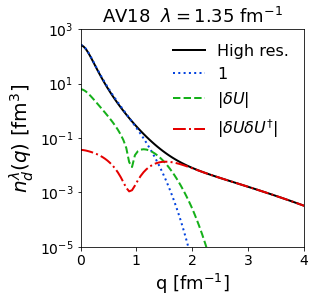

In [4]:
# # Plot for AV18 at \lambda = 1.35 (loop over contributions)

# kvnn = 6
# lamb = 1.35
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# curves = (1, 2, 3, 4)

# for curve in curves:
#     f, ax = n_lambda_deuteron_decomposition(kvnn, lamb, kmax, kmid, ntot, curve)

#     # Add kvnn, \lambda label to plot as title
#     label = 'AV18  ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
#     label_size = 18
#     ax.set_title(label, fontsize=label_size)

#     # Set file name
#     file_name = 'n_lambda_deuteron_decomposition_kvnn_%d_lamb_%.2f_curves_%d' % (kvnn, lamb, curve)
#     # file_name = ff.replace_periods(file_name) + '.pdf'
#     file_name = ff.replace_periods(file_name) + '.png'

#     # Save figure
#     chdir('Figures/SRC_physics/SRC_2021_workshop_figures')
#     f.savefig(file_name, bbox_inches='tight')
#     chdir(cwd)

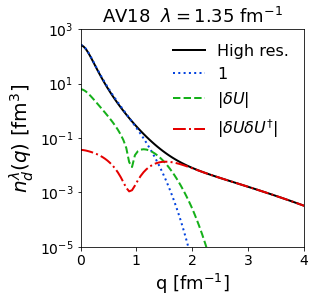

In [5]:
# # Plot for AV18 at \lambda = 1.35 (all contributions at once)

# kvnn = 6
# lamb = 1.35
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# curves = 4

# f, ax = n_lambda_deuteron_decomposition(kvnn, lamb, kmax, kmid, ntot, curves)

# # Add kvnn, \lambda label to plot as title
# label = 'AV18  ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# label_size = 18
# ax.set_title(label, fontsize=label_size)

# # Set file name
# file_name = 'n_lambda_deuteron_decomposition_kvnn_%d_lamb_%.2f_curves_%d' % (kvnn, lamb, curves)
# # file_name = ff.replace_periods(file_name) + '.pdf'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# chdir('Figures/SRC_physics/SRC_2021_workshop_figures')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

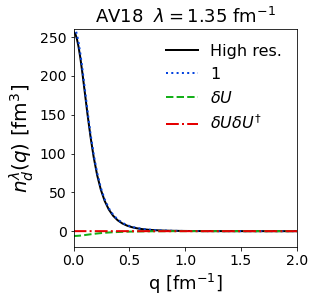

In [6]:
# # Plot for AV18 at \lambda = 1.35 on a linear scale (all contributions at once)

# kvnn = 6
# lamb = 1.35
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# curves = 4

# xlim = (0.0, 2.0)
# ylim = (-20.0, 260.0)

# f, ax = n_lambda_deuteron_decomposition(kvnn, lamb, kmax, kmid, ntot, curves, xlim, ylim)

# # Add kvnn, \lambda label to plot as title
# label = 'AV18  ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# label_size = 18
# ax.set_title(label, fontsize=label_size)

# # Set file name
# file_name = 'n_lambda_deuteron_decomposition_kvnn_%d_lamb_%.2f_curves_%d_linear_y' % (kvnn, lamb, curves)
# # file_name = ff.replace_periods(file_name) + '.pdf'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# chdir('Figures/SRC_physics/SRC_2021_workshop_figures')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Deuteron $^{3}S_1$ / ($^{3}S_1-^{3}D_1$) ratio for high-$q$ term__

In [7]:
def deuteron_3S1_3D1_ratios(kvnns, lamb, xlim=(0, 4), ylim=(0, 1)):
    """
    Plots the 3S1 / 3S1-3D1 ratio of the \delta U \delta U^\dagger SRG-evolved deuteron pair momentum
    distribution term .
    
    Parameters
    ----------
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1]. Will use potential's default value if no argument is
        entered.
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1]. Will use potential's default value if no argument is
        entered.
    ntot : int, optional
        Number of momentum points in mesh. Will use potential's default value if no argument is entered.
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [unitless].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    
    # --- Set up --- #
    
    # Initialize dictionary to store evolved potentials and momentum arrays
    d = {}
    
    # Loop over kvnns
    for kvnn in kvnns:
    
        d[kvnn] = {} 
    
        # Load momentum
        q_array, _ = vnn.load_momentum(kvnn, '3S1')
        d[kvnn]['q_array'] = q_array
    
        # Load n_\lambda_d(q) for given potential
        dmd = deuteron_momentum_distributions(kvnn, lamb, kmax, kmid, ntot)

        # Load evolved wave function here (unitless)
        H_initial = vnn.load_hamiltonian(kvnn, '3S1')
        H_evolved = vnn.load_hamiltonian(kvnn, '3S1', method='srg', generator='Wegner', lamb=lamb)
        U_matrix_unitless = SRG_unitary_transformation(H_initial, H_evolved)
        psi_deuteron = ob.wave_function(H_initial, U=U_matrix_unitless) # Unitless
    
        # Now calculate ratio
        ratio_array = np.zeros(ntot)
        for iq, q in enumerate(q_array):
            # First return is just the total pair momentum distribution - we don't need it here
            _, ratio_array[iq] = dmd.n_lambda_pair_exact(q, contributions='partial_wave_ratio')
        
        # Store in dictionary
        d[kvnn]['ratio'] = ratio_array
    
    
    # --- Plot --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)
        
    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    # y_label = r'$n^{\lambda}_d(q)$' + ' ratio'
    y_label = r'$\delta U \delta U^{\dagger}$' + ' ratio'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0

    # Subplot labels
    legend_size = 16
    legend_location = 'lower right'

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Add horizontal line at ratio = 1
    ax.axhline(1.0, color='xkcd:black', linestyle='dotted')
    
    # Loop over kvnns
    for i, kvnn in enumerate(kvnns):
        
        curve_color = ff.xkcd_colors(i)
        # curve_style = ff.line_styles(i)
        curve_label = ff.kvnn_label_conversion(kvnn)
        
        ax.plot(d[kvnn]['q_array'], d[kvnn]['ratio'], color=curve_color, linestyle='solid',
                label=curve_label, linewidth=curve_width)
        
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set axes labels, legend, and anchored text labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)
    
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

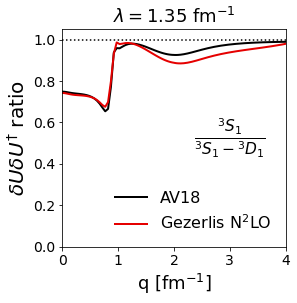

In [8]:
# # Plot for AV18 and Gezerlis N2LO 1 fm at \lambda = 1.35

# kvnns = (6, 222)
# lamb = 1.35
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# ylim = (0.0, 1.05)

# f, ax = deuteron_3S1_3D1_ratios(kvnns, lamb, ylim=ylim)

# # Add \lambda label to plot as title
# lambda_label = r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# lambda_label_size = 18
# ax.set_title(lambda_label, fontsize=lambda_label_size)

# # Add 3S1 only / 3S1-3D1 label
# ratio_label = r'$\frac{^{3}S_1}{^{3}S_1-^{3}D_1}$'
# ratio_label_location = 'center right'
# ratio_label_size = 22
# anchored_text = AnchoredText(ratio_label, loc=ratio_label_location, prop=dict(size=ratio_label_size),
#                              frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'deuteron_3S1_3D1_ratios_lamb_%.2f_kvnns' % lamb
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# # file_name = ff.replace_periods(file_name) + '.pdf'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# chdir('Figures/SRC_physics/SRC_2021_workshop_figures')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Factorization of $\delta U \delta U^{\dagger}$__

In [9]:
def factorization_ratios(k_0, k_points, kvnn, channel, lamb, xlim=(0.0, 5.0), ylim=(1e-1, 1e1)):
    """
    Plots the ratio of \delta U \delta U^{\dagger} with respect to momentum [fm^-1] for k = k_points in the 
    numerator and k = k_0 in the denominator, and k' = q_array.
    
    Parameters
    ----------
    k_0 : float
        Momentum value for U(k_0, q) in the denominator [fm^-1].
    k_points : 1-D ndarray
        Array of momentum values for U(k_points, q) in the numerator [fm^-1].
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    lamb : float
        Evolution parameter lambda [fm^-1].
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [unitless].

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
     
    # --- Set-up --- #
    
    # Initialize dictionary to store ratio at each k_i point
    d = {}

    # Load momentum and weights
    q_array, q_weights = vnn.load_momentum(kvnn, channel)

    # Number of points in momentum array
    ntot = len(q_array)
    # Use factor_array to divide out momenta/weights for mesh-independent result
    if vnn.coupled_channel(channel):
        factor_array = np.concatenate( (np.sqrt(q_weights) * q_array, np.sqrt(q_weights) * q_array) ) * \
                       np.sqrt(2/np.pi)
    else:
        factor_array = np.sqrt(2*q_weights/np.pi) * q_array
    row, col = np.meshgrid(factor_array, factor_array)
    
    # Load initial and evolved Hamiltonians
    H_initial = vnn.load_hamiltonian(kvnn, channel)
    H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', lamb=lamb)
    
    # Calculate SRG transformation
    U_matrix_unitless = SRG_unitary_transformation(H_initial, H_evolved)
    
    # Converting to units [fm^3]
    I_matrix_unitless = np.eye( len(factor_array), len(factor_array) )
    delta_U_matrix_unitless = U_matrix_unitless - I_matrix_unitless
    delta_U_matrix = delta_U_matrix_unitless / row / col
    
    # Obtain \delta U(k_0, q) \delta U^{\dagger}(q, k_0) array
    k_0_index = op.find_q_index(k_0, q_array)
    delU_squared_denominator = delta_U_matrix[k_0_index, :ntot] * delta_U_matrix.T[:ntot, k_0_index]
    
    # Loop over k_i in k_points
    for k_i in k_points:
        
        # Index of k_i in q_array
        k_i_index = op.find_q_index(k_i, q_array)
            
        # Obtain U(k_i, q) array
        delU_squared_numerator = delta_U_matrix[k_i_index, :ntot] * delta_U_matrix.T[:ntot, k_i_index]
        
        # Calculate ratio and store in dictionary with k_i as the key
        d[k_i] = abs(delU_squared_numerator / delU_squared_denominator)
            

    # --- Plot --- #
    
    # Size of figure
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)
    
    # Axes ticks, labels, and fontsizes
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    x_stepsize = 1.0
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    x_ticks_strings = ff.convert_ticks_to_labels(x_ticks)
    y_label = r'$\delta U \delta U^{\dagger}(k, q)$' + ' ratio'
    y_label_size = 18
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0
    
    # Subplot labels
    legend_size = 15
    legend_location = 'upper left'
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(row_number, col_number, figsize=figure_size)
    
    # Loop over kvnns keeping track of indices
    for i, k_i in enumerate(k_points):
            
        # Curve color, styles, and labels
        curve_color = ff.xkcd_colors(i)
        curve_style = ff.line_styles(i)
        curve_label = r'$k_{%d}=%.1f$' % (i+1, k_i) + ' fm' + r'$^{-1}$'
            
        # Add curve to figure
        ax.semilogy(q_array, d[k_i], color=curve_color, label=curve_label, linestyle=curve_style,
                    linewidth=curve_width)
            
    # Shade gray from 0 to \lambda or \Lambda_BD value on plot
    ax.fill_betweenx(ylim, 0, lamb, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)
            
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set axes labels, legend, and anchored text labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0, frameon=False,
              fontsize=legend_size)
                     
    return f, ax

In [10]:
# # Factorization ratios for AV18 at \lambda=1.35 fm^-1

# k_0 = 0.1
# k_points = (0.3, 0.7, 1.0, 2.0)
# kvnn = 6
# channel = '3S1'
# lamb = 1.35
# f, ax = factorization_ratios(k_0, k_points, kvnn, channel, lamb)

# # Set file name
# file_name = 'factorization_ratios_kvnn_%d_%s_k0_%.1f_kpoints' % (kvnn, channel, k_0)
# for k_i in k_points:
#     file_name += '_%.1f' % k_i
# # file_name = ff.replace_periods(file_name) + '.pdf'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# chdir('Figures/SRC_physics/SRC_2021_workshop_figures')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [11]:
# # Factorization ratios for Gezerlis N2LO 1 fm at \lambda=1.35 fm^-1

# k_0 = 0.1
# k_points = (0.3, 0.7, 1.0, 2.0)
# kvnn = 222
# channel = '3S1'
# lamb = 1.35
# f, ax = factorization_ratios(k_0, k_points, kvnn, channel, lamb)

# # Set file name
# file_name = 'factorization_ratios_kvnn_%d_%s_k0_%.1f_kpoints' % (kvnn, channel, k_0)
# for k_i in k_points:
#     file_name += '_%.1f' % k_i
# # file_name = ff.replace_periods(file_name) + '.pdf'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# chdir('Figures/SRC_physics/SRC_2021_workshop_figures')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Ratio of ($^{3}S_1-^{3}D_1$) / $^{1}S_0$ SRG transformations__

In [12]:
def srg_transformation_ratios_fixed_k(k_0, kvnns, lamb, xlim=(0.0, 800.0), ylim=(1e0, 1e3)):
    """
    Plots ratios of |U(k_0, q)_{3S1-3D1}|^2 / |U(k_0, q)_{1S0}|^2 with respect to momentum k [fm^-1] where
    k_0 < \lambda.
    
    Parameters
    ----------
    k_0 : float
        k_0 value in the ratio U(k_0, q)_{3S1} / U(k_0, q)_{1S0} [fm^-1].
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (6, 222)).
    lamb : float
        Evolution parameter lambda [fm^-1].
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis (which is log scale and unitless).
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """

    # --- Set up --- #
    
    # Store results in dictionary where kvnns are the keys
    d = {}
    
    for kvnn in kvnns:
    
        # Load momentum and weights (channel argument doesn't matter here)
        k_array, k_weights = vnn.load_momentum(kvnn, '1S0')
    
        # Length of the momentum array
        ntot = len(k_array)
    
        # Divide out integration factors with factor_array
        factor_array = np.sqrt( (2*k_weights) / np.pi ) * k_array
        row, col = np.meshgrid(factor_array, factor_array)
        # Same thing but for coupled-channel
        factor_array_cc = np.concatenate( (factor_array, factor_array) )
        row_cc, col_cc = np.meshgrid(factor_array_cc, factor_array_cc)
    
        # Load initial and evolved Hamiltonians [MeV], and SRG transformations
        # 1S0
        H_initial_1s0 = vnn.load_hamiltonian(kvnn, '1S0')
        H_evolved_1s0 = vnn.load_hamiltonian(kvnn, '1S0', method='srg', lamb=lamb)
        # 3S1
        H_initial_3s1 = vnn.load_hamiltonian(kvnn, '3S1')
        H_evolved_3s1 = vnn.load_hamiltonian(kvnn, '3S1', method='srg', lamb=lamb)
    
        # Calculate SRG transformation with eigenvectors of initial and evolved Hamiltonians dividing out 
        # integration factors
        U_matrix_1s0 = SRG_unitary_transformation(H_initial_1s0, H_evolved_1s0) / row / col
        U_matrix_3s1 = SRG_unitary_transformation(H_initial_3s1, H_evolved_3s1) / row_cc / col_cc
    
        # Index of k_0 in k_array
        k_0_index = op.find_q_index(k_0, k_array)
        
        # Calculate |U(k_0, q)_{3S1}|^2
        numerator_array = U_matrix_3s1[k_0_index, :ntot] * U_matrix_3s1.T[:ntot, k_0_index] + \
                          U_matrix_3s1[k_0_index, ntot:] * U_matrix_3s1.T[ntot:, k_0_index]
        
        # Calculate |U(k, q_i)_{1S0}|^2
        denominator_array = U_matrix_1s0[k_0_index, :ntot] * U_matrix_1s0.T[:ntot, k_0_index]
        
        # Store ratio in dictionary
        d[kvnn] = numerator_array / denominator_array
        
        
    # --- Plot ratios --- #
    
    # Convert x-axis to MeV
    hbar_c = 197.326 # MeV*fm
    e_array = k_array * hbar_c

    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [MeV]'
    x_label_size = 18
    # y_label = r'$n_{\lambda}(q)$' + ' ratio'
    y_label = r'$U_{\lambda}(k_0, q)$' + ' ratio'
    y_label_size = 20
    axes_tick_size = 14
    
    # Legend label
    legend_size = 15
    legend_location = 'lower left'

    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # Loop over kvnns keeping track of index
    for i, kvnn in enumerate(kvnns):
        
        # Curve color and label
        curve_color = ff.xkcd_colors(i)
        curve_label = ff.kvnn_label_conversion(kvnn)
        
        # Add curve to figure
        ax.semilogy(e_array, d[kvnn], color=curve_color, label=curve_label, linestyle='solid',
                    linewidth=curve_width)
        
    # Shade gray from 0 to \lambda or \Lambda_BD value on plot
    ax.fill_betweenx(ylim, 0.0, lamb * hbar_c, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels and legend
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    #ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., fontsize=legend_size)
    ax.legend(loc=legend_location, fontsize=13)

    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

In [13]:
# # Ratio of U_3S1 / U_1S0 as a function of q for AV18 and Gezerlis N2LO 1 fm at \lambda = 1.35 fm^-1

# k_0 = 0.1
# kvnns = (6, 222)
# lamb = 1.35
# f, ax = srg_transformation_ratios_fixed_k(k_0, kvnns, lamb)

# # Add 3S1-3D1 / 1S0 label
# ratio_label = r'$\frac{^{3}S_1-^{3}D_1}{^{1}S_0}$'
# ratio_label_location = 'upper right'
# ratio_label_size = 20
# anchored_text = AnchoredText(ratio_label, loc=ratio_label_location, prop=dict(size=ratio_label_size),
#                              frameon=False)
# ax.add_artist(anchored_text)

# # Save figure
# file_name = 'srg_transformation_ratios_k0_%.1f_lamb_%.2f_kvnns' % (k_0, lamb)
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# # file_name = ff.replace_periods(file_name) + '.pdf'
# file_name = ff.replace_periods(file_name) + '.png'

# chdir('Figures/SRC_physics/SRC_2021_workshop_figures')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__$S$-wave dominance at high-$q$__

In [14]:
def partial_wave_ratios(nuclei_list, kvnn, lamb, kmax=0.0, kmid=0.0, ntot=0, xlim=(0, 800), ylim=(0, 1)):
    """
    Plots the ratio of the pair momentum distribution under LDA taking only S-waves over S+P+D-waves.
    
    Parameters
    ----------
    nuclei_list : list
        List that contains the details for various nuclei formatted as another list:
        [name (str), Z (int), N (int)] (e.g., nuclei_list[i] = ['O16', 8, 8]).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1]. Will use potential's default value if no argument is
        entered.
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1]. Will use potential's default value if no argument is
        entered.
    ntot : int, optional
        Number of momentum points in mesh. Will use potential's default value if no argument is entered.
    xlim : tuple, optional
        Limits of x-axis [MeV].
    ylim : tuple, optional
        Limits of y-axis [unitless].
    
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    
    # --- Set up --- #
    
    # Calculate for pp and pn pairs
    pairs = ('pp', 'pn')
    
    # Load momentum
    q_array, _ = vnn.load_momentum(kvnn, '1S0', kmax, kmid, ntot)
    
    # S-waves only
    channels_S = ('1S0', '3S1')
    # S-, P-, and D-waves
    channels_SPD = ('1S0', '3S1', '3P0', '1P1', '3P1', '3P2', '1D2', '3D2', '3D3')
    
    # Initialize pair momentum distributions class
    pmd_S = pair_momentum_distributions(kvnn, channels_S, lamb, kmax, kmid, ntot)
    pmd_SPD = pair_momentum_distributions(kvnn, channels_SPD, lamb, kmax, kmid, ntot)
    
    # Initialize dictionary
    d = {}
    
    # Loop over nuclei
    for nucleus in nuclei_list:
        
        name = nucleus[0]
        Z = nucleus[1]
        N = nucleus[2]
        A = N + Z
        
        d[name] = {}
        
        r_array, rho_p_array = load_density(name, 'proton', Z, N)
        r_array, rho_n_array = load_density(name, 'neutron', Z, N)
        
        # Call LDA class
        lda = LDA(r_array, rho_p_array, rho_n_array)
        
        # Loop over pairs
        for pair in pairs:
        
            # Calculate momentum distributions
            if pair == 'pp':
                n_array_S = lda.local_density_approximation(q_array, pmd_S.n_lambda_pp, pair)
                n_array_SPD = lda.local_density_approximation(q_array, pmd_SPD.n_lambda_pp, pair)
            elif pair == 'pn':
                n_array_S = lda.local_density_approximation(q_array, pmd_S.n_lambda_pn, pair)
                n_array_SPD = lda.local_density_approximation(q_array, pmd_SPD.n_lambda_pn, pair)
            
            # Store ratio in dictionary for each nucleus
            d[name][pair] = n_array_S / n_array_SPD
        
    
    # --- Plot --- #
    
    # Convert x-axis to MeV
    hbar_c = 197.326 # MeV*fm
    e_array = q_array * hbar_c
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)
        
    # Axes labels and fontsize
    x_label = 'q [MeV]'
    x_label_size = 18
    y_label = r'$n^{\lambda}_A(q,Q=0)$' + ' ratio'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # Loop over nuclei
    for i, nucleus in enumerate(nuclei_list):
        
        curve_color = ff.xkcd_colors(i)
        A = nucleus[1] + nucleus[2]
        if A < 20:
            name = nucleus[0][0]
        else:
            name = nucleus[0][0:2]
        
        # Loop over pairs
        for j, pair in enumerate(pairs):
          
            if pair == 'pp':
                curve_style = 'dotted'
                curve_label = ''
            else:
                curve_style = 'solid'
                curve_label = r'$^{%d}$' % A + name
        
            ax.plot(e_array, d[ nucleus[0] ][pair], color=curve_color, linestyle=curve_style, label=curve_label,
                    linewidth=curve_width)
        
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set axes labels and anchored text labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

In [15]:
# # Plot ratio of S-wave contributions to n_{\lambda}(q, Q=0) over S-, P-, and D-wave contributions

# nuclei_list = [ ['C12', 6, 6], ['O16', 8, 8], ['Ca40', 20, 20], ['Ca48', 20, 28], ['Pb208', 82, 126] ]
# kvnn = 6
# lamb = 1.35
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# xlim = (300, 800) # Just show high-q tail.
# ylim = (0.0, 1.0)

# f, ax = partial_wave_ratios(nuclei_list, kvnn, lamb, kmax, kmid, ntot, xlim, ylim)

# # Add legend for nuclei
# legend_size = 15
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., fontsize=legend_size)

# # Add kvnn, \lambda label to plot as title
# label = 'AV18  ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# label_size = 18
# ax.set_title(label, fontsize=label_size)

# # Add ratio label
# ratio_label = r'$\frac{S-\rm{waves}}{S+P+D-\rm{waves}}$'
# ratio_label_location = 'lower right'
# ratio_label_size = 18
# anchored_text = AnchoredText(ratio_label, loc=ratio_label_location, prop=dict(size=ratio_label_size),
#                              frameon=False)
# ax.add_artist(anchored_text)

# # Add pair label
# pair_label = 'pp dotted\npn solid'
# pair_label_location = 'center right'
# pair_label_size = 17
# anchored_text = AnchoredText(pair_label, loc=pair_label_location, prop=dict(size=pair_label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'partial_wave_ratios_kvnn_%d_lamb_%.2f' % (kvnn, lamb)
# # file_name = ff.replace_periods(file_name) + '.pdf'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# chdir('Figures/SRC_physics/SRC_2021_workshop_figures')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__High-$q$ pp/pn ratios of $n_{\lambda}^A(q,Q=0)$__

In [16]:
def pp_pn_ratios(nuclei_list, channels, kvnn, lamb, kmax=0.0, kmid=0.0, ntot=0, xlim=(0, 800), ylim=(0, 1)):
    """
    Plots the ratio of pp/pn pairs in nuclei under LDA.
    
    Parameters
    ----------
    nuclei_list : list
        List that contains the details for various nuclei formatted as another list:
        [name (str), Z (int), N (int)] (e.g., nuclei_list[i] = ['O16', 8, 8]).
    channels : tuple
        Partial wave channels to include in the calculation.
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1]. Will use potential's default value if no argument is
        entered.
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1]. Will use potential's default value if no argument is
        entered.
    ntot : int, optional
        Number of momentum points in mesh. Will use potential's default value if no argument is entered.
    xlim : tuple, optional
        Limits of x-axis [MeV].
    ylim : tuple, optional
        Limits of y-axis [unitless].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    
    # --- Set up --- #
    
    # Load momentum
    q_array, _ = vnn.load_momentum(kvnn, '1S0', kmax, kmid, ntot)
    
    # Initialize pair momentum distributions class
    pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot)
    
    # Initialize dictionary
    d = {}
    
    # Loop over nuclei
    for nucleus in nuclei_list:
        
        name = nucleus[0]
        Z = nucleus[1]
        N = nucleus[2]
        A = N + Z
        r_array, rho_p_array = load_density(name, 'proton', Z, N)
        r_array, rho_n_array = load_density(name, 'neutron', Z, N)
        
        # Call LDA class
        lda = LDA(r_array, rho_p_array, rho_n_array)
    
        # Calculate momentum distributions
        n_pp_array = lda.local_density_approximation(q_array, pmd.n_lambda_pp, 'pp')
        n_pn_array = lda.local_density_approximation(q_array, pmd.n_lambda_pn, 'pn')
        
        # Store pp/pn ratio in dictionary for each nucleus
        # Factor of 2 is because pn = np and we want pp / (pn+np)
        d[name] = n_pp_array / (2*n_pn_array)
    
    
    # --- Plot --- #
    
    # Convert x-axis to MeV
    hbar_c = 197.326 # MeV*fm
    e_array = q_array * hbar_c
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)
        
    # Axes labels and fontsize
    x_label = 'q [MeV]'
    x_label_size = 18
    y_label = r'$n^{\lambda}_A(q,Q=0)$' + ' ratio'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # Loop over nuclei
    for i, nucleus in enumerate(nuclei_list):
        
        curve_color = ff.xkcd_colors(i)
        curve_style = ff.line_styles(i)
        A = nucleus[1] + nucleus[2]
        if A < 20:
            name = nucleus[0][0]
        else:
            name = nucleus[0][0:2]
        curve_label = r'$^{%d}$' % A + name
        
        ax.plot(e_array, d[ nucleus[0] ], color=curve_color, linestyle=curve_style, label=curve_label,
                linewidth=curve_width)
        
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set axes labels and anchored text labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

In [17]:
# # Plot for AV18 at \lambda = 1.35 fm^-1 (S-waves only)

# nuclei_list = [ ['C12', 6, 6], ['O16', 8, 8], ['Ca40', 20, 20], ['Ca48', 20, 28], ['Pb208', 82, 126] ]
# channels = ('1S0', '3S1')
# kvnn = 6
# lamb = 1.35
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# xlim = (300, 800) # Just show high-q tail.
# ylim = (0.0, 0.3)

# f, ax = pp_pn_ratios(nuclei_list, channels, kvnn, lamb, kmax, kmid, ntot, xlim, ylim)

# # Add legend for nuclei
# legend_size = 15
# legend_location = 'upper left'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add kvnn, \lambda label to plot as title
# label = 'AV18  ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# label_size = 18
# ax.set_title(label, fontsize=label_size)

# # Add pp/nn label
# ratio_label = r'$\frac{pp}{pn}$'
# ratio_label_location = 'upper right'
# ratio_label_size = 26
# anchored_text = AnchoredText(ratio_label, loc=ratio_label_location, prop=dict(size=ratio_label_size),
#                              frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'pp_pn_ratios_channels'
# for channel in channels:
#     file_name += '_%s' % channel
# file_name += '_kvnn_%d_lamb_%.2f' % (kvnn, lamb)
# # file_name = ff.replace_periods(file_name) + '.pdf'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# chdir('Figures/SRC_physics/SRC_2021_workshop_figures')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [18]:
# # Plot for AV18 at \lambda = 1.35 fm^-1 (S-, P-, and D-waves)

# nuclei_list = [ ['C12', 6, 6], ['O16', 8, 8], ['Ca40', 20, 20], ['Ca48', 20, 28], ['Pb208', 82, 126] ]
# channels = ('1S0', '3S1', '3P0', '1P1', '3P1', '3P2', '1D2', '3D2', '3D3')
# kvnn = 6
# lamb = 1.35
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# xlim = (300, 800) # Just show high-q tail.
# ylim = (0.0, 0.3)

# f, ax = pp_pn_ratios(nuclei_list, channels, kvnn, lamb, kmax, kmid, ntot, xlim, ylim)

# # Add legend for nuclei
# legend_size = 13
# legend_location = 'upper left'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add kvnn, \lambda label to plot as title
# label = 'AV18  ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# label_size = 18
# ax.set_title(label, fontsize=label_size)

# # Add pp/nn label
# ratio_label = r'$\frac{pp}{pn}$'
# ratio_label_location = 'upper right'
# ratio_label_size = 26
# anchored_text = AnchoredText(ratio_label, loc=ratio_label_location, prop=dict(size=ratio_label_size),
#                              frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'pp_pn_ratios_channels'
# for channel in channels:
#     file_name += '_%s' % channel
# file_name += '_kvnn_%d_lamb_%.2f' % (kvnn, lamb)
# # file_name = ff.replace_periods(file_name) + '.pdf'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# chdir('Figures/SRC_physics/SRC_2021_workshop_figures')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__High-$q$ $\frac{pp+pn}{nn+np}$ ratios of $n_{\lambda}^A(q,Q=0)$__

In [19]:
def p_n_ratios(nuclei_list, channels, kvnn, lamb, kmax=0.0, kmid=0.0, ntot=0, xlim=(0, 800), ylim=(0, 1)):
    """
    Plots the ratio of (pp+pn)/(nn+np) pairs in nuclei under LDA.
    
    Parameters
    ----------
    nuclei_list : list
        List that contains the details for various nuclei formatted as another list:
        [name (str), Z (int), N (int)] (e.g., nuclei_list[i] = ['O16', 8, 8]).
    channels : tuple
        Partial wave channels to include in the calculation.
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1]. Will use potential's default value if no argument is
        entered.
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1]. Will use potential's default value if no argument is
        entered.
    ntot : int, optional
        Number of momentum points in mesh. Will use potential's default value if no argument is entered.
    xlim : tuple, optional
        Limits of x-axis [MeV].
    ylim : tuple, optional
        Limits of y-axis [unitless].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    
    # --- Set up --- #
    
    # Load momentum
    q_array, _ = vnn.load_momentum(kvnn, '1S0', kmax, kmid, ntot)
    
    # Initialize pair momentum distributions class
    pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot)
    
    # Initialize dictionary
    d = {}
    
    # Loop over nuclei
    for nucleus in nuclei_list:
        
        name = nucleus[0]
        Z = nucleus[1]
        N = nucleus[2]
        A = N + Z
        r_array, rho_p_array = load_density(name, 'proton', Z, N)
        r_array, rho_n_array = load_density(name, 'neutron', Z, N)
        
        # Call LDA class
        lda = LDA(r_array, rho_p_array, rho_n_array)
    
        # Calculate momentum distributions
        n_pp_array = lda.local_density_approximation(q_array, pmd.n_lambda_pp, 'pp')
        n_pn_array = lda.local_density_approximation(q_array, pmd.n_lambda_pn, 'pn')
        # np is the same as pn
        n_nn_array = lda.local_density_approximation(q_array, pmd.n_lambda_pp, 'nn')
        
        # Store ratio in dictionary for each nucleus
        d[name] = (n_pp_array + n_pn_array) / (n_nn_array + n_pn_array)

        
    # --- Plot --- #
    
    # Convert x-axis to MeV
    hbar_c = 197.326 # MeV*fm
    e_array = q_array * hbar_c
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)
        
    # Axes labels and fontsize
    x_label = 'q [MeV]'
    x_label_size = 18
    y_label = r'$n^{\lambda}_A(q,Q=0)$' + ' ratio'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # Loop over nuclei
    for i, nucleus in enumerate(nuclei_list):
        
        curve_color = ff.xkcd_colors(i)
        curve_style = ff.line_styles(i)
        A = nucleus[1] + nucleus[2]
        if A < 20:
            name = nucleus[0][0]
        else:
            name = nucleus[0][0:2]
        curve_label = r'$^{%d}$' % A + name
        
        ax.plot(e_array, d[ nucleus[0] ], color=curve_color, linestyle=curve_style, label=curve_label,
                linewidth=curve_width)
        
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set axes labels and anchored text labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

In [20]:
# # Plot for AV18 at \lambda = 1.35 fm^-1 (S-waves only)

# nuclei_list = [ ['C12', 6, 6], ['O16', 8, 8], ['Ca40', 20, 20], ['Ca48', 20, 28], ['Pb208', 82, 126] ]
# channels = ('1S0', '3S1')
# kvnn = 6
# lamb = 1.35
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# xlim = (300, 800) # Currently we have the wrong low-momentum part. Just show high-q tail.
# ylim = (0.8, 1.2)

# f, ax = p_n_ratios(nuclei_list, channels, kvnn, lamb, kmax, kmid, ntot, xlim, ylim)

# # Add legend label for nuclei
# legend_size = 15
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., fontsize=legend_size)

# # Add kvnn, \lambda label to plot as title
# label = 'AV18  ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# label_size = 18
# ax.set_title(label, fontsize=label_size)

# # Add pp/nn label
# ratio_label = r'$\frac{pp+pn}{nn+np}$'
# ratio_label_location = 'upper left'
# ratio_label_size = 27
# anchored_text = AnchoredText(ratio_label, loc=ratio_label_location, prop=dict(size=ratio_label_size),
#                              frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'p_n_ratios_channels'
# for channel in channels:
#     file_name += '_%s' % channel
# file_name += '_kvnn_%d_lamb_%.2f' % (kvnn, lamb)
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# chdir('Figures/SRC_physics/SRC_2021_workshop_figures')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [21]:
# # Plot for AV18 at \lambda = 1.35 fm^-1 (S-, P-, and D-waves)

# nuclei_list = [ ['C12', 6, 6], ['O16', 8, 8], ['Ca40', 20, 20], ['Ca48', 20, 28], ['Pb208', 82, 126] ]
# channels = ('1S0', '3S1', '3P0', '1P1', '3P1', '3P2', '1D2', '3D2', '3D3')
# kvnn = 6
# lamb = 1.35
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# xlim = (300, 800) # Currently we have the wrong low-momentum part. Just show high-q tail.
# ylim = (0.8, 1.2)

# f, ax = p_n_ratios(nuclei_list, channels, kvnn, lamb, kmax, kmid, ntot, xlim, ylim)

# # Add legend label for nuclei
# legend_size = 15
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., fontsize=legend_size)

# # Add kvnn, \lambda label to plot as title
# label = 'AV18  ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# label_size = 18
# ax.set_title(label, fontsize=label_size)

# # Add pp/nn label
# ratio_label = r'$\frac{pp+pn}{nn+np}$'
# ratio_label_location = 'upper left'
# ratio_label_size = 27
# anchored_text = AnchoredText(ratio_label, loc=ratio_label_location, prop=dict(size=ratio_label_size),
#                              frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'p_n_ratios_channels'
# for channel in channels:
#     file_name += '_%s' % channel
# file_name += '_kvnn_%d_lamb_%.2f' % (kvnn, lamb)
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# chdir('Figures/SRC_physics/SRC_2021_workshop_figures')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__$a_2$ scaling factors with respect to $A$__

In [22]:
# To do:
#   1. Figure out factor of 2/\pi and/or 2*J+1 for deuteron.
#   2. Test mesh dependence in evaluation of a2.
#   3. Test N2LO.
#   4. Show pp, pn, nn contributions and switch to bar chart.
def a2_scaling_factors(nuclei_list, kvnn, lamb, kmax=0.0, kmid=0.0, ntot=0, write_files=False, asymptotic=False,
                       xlim=(1e0, 3e2), ylim=(3, 6)):
    """
    Edit this when you include pp, pn contributions...
    
    """
    
    # --- Set up --- #
    
    # Directory where momentum distributions are written
    data_directory = 'Figures/SRC_physics/Momentum_distribution_data/' 
    
    # Number of nuclei
    Atot = len(nuclei_list)
    
    # Load momentum
    q_array, q_weights = vnn.load_momentum(kvnn, '1S0', kmax, kmid, ntot)
    
    # Set integration limits for extraction of a_2
    # Asymptotic limit: 3.8 - 4.5 fm^-1 as in Ryckebusch paper
    if asymptotic:
        q_start_index = op.find_q_index(3.8, q_array)
        q_stop_index = op.find_q_index(4.5, q_array)
    # Start integrals at 2 fm^-1    
    else:
        q_start_index = op.find_q_index(2, q_array)
        q_stop_index = len(q_array)
    
    # This is 4 \pi for d\omega and 1/(2*\pi)^3 for d3q
    overall_factor = 4*np.pi * 1/(2*np.pi)**3
    
    if write_files:
        
        # Initialize single-nucleon momentum distributions class
        channels = ('1S0', '3S1', '3P0', '1P1', '3P1', '3P2')
        snmd = single_nucleon_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot)

        # Deuteron denominator
        dmd = deuteron_momentum_distributions(kvnn, lamb, kmax, kmid, ntot)
        t0 = time.time()
        n_deuteron = dmd.local_density_approximation(q_array, 'single-nucleon')
        t1 = time.time() # End time
        mins = round( (t1 - t0) / 60.0, 2)
        print('Deuteron done after %.2f minutes' % mins)
        
        f = open(data_directory + 'n_deuteron_kvnn_%d_kmax_%d.dat' % (kvnn, kmax), 'w')
        for ele in n_deuteron:
            f.write( '{:.5e}'.format(ele) + '\n')
        f.close()
        
    else:
        
        n_deuteron = np.loadtxt(data_directory + 'n_deuteron_kvnn_%d_kmax_%d.dat' % (kvnn, kmax) )
        
    # This gives roughly the same high-momentum tail in deuteron as in the exact momentum distribution
    # That momentum distribution is normalized to 1
    p_a_deuteron = 2/np.pi * q_array**2 * n_deuteron / 2 * overall_factor
    # print('Normalization of 2/\pi * p_a_deuteron/2 = %.3e' % np.sum( q_weights * p_a_deuteron ) )
    # print('Normalization of 2/\pi * p_a_deuteron/2 = %.3e' % np.sum( (q_weights * p_a_deuteron)[q_start_index:] ) )
    denominator = np.sum( (q_weights * p_a_deuteron)[q_start_index:q_stop_index] )
    # print('Deuteron=%.3e' % denominator)
    
    # Loop over nuclei
    A_array = np.zeros(Atot)
    a2_array = np.zeros(Atot)
    for i, nucleus in enumerate(nuclei_list):
        
        name = nucleus[0]
        Z = nucleus[1]
        N = nucleus[2]
        A = N + Z
        A_array[i] = A
        
        if write_files:
        
            r_array, rho_p_array = load_density(name, 'proton', Z, N)
            r_array, rho_n_array = load_density(name, 'neutron', Z, N)
    
            # Call LDA class
            lda = LDA(r_array, rho_p_array, rho_n_array)
            
            # n(q) single-particle
            t0 = time.time()
            n_p_array = lda.local_density_approximation( q_array, snmd.n_lambda, 'p' )
            n_n_array = lda.local_density_approximation( q_array, snmd.n_lambda, 'n' )
            t1 = time.time() # End time
            mins = round( (t1 - t0) / 60.0, 2)
            print('-'*50)
            print('A=%d done after %.2f minutes' % (A, mins) )
            
            g = open(data_directory + 'n_%s_kvnn_%d_kmax_%d.dat' % (name, kvnn, kmax), 'w')
            for ele1, ele2 in zip(n_p_array, n_n_array):
                g.write('{:^20.5e}{:^20.5e}'.format(ele1, ele2) + '\n' )
            g.close()
            
        else:
            
            data = np.loadtxt( data_directory + 'n_%s_kvnn_%d_kmax_%d.dat' % (name, kvnn, kmax) )
            n_p_array = data[:, 0]
            n_n_array = data[:, 1]
            
    
        # BUG: this doesn't work for asymmetric nuclei for some reason
        p_a_p = q_array**2 * n_p_array / A * overall_factor
        p_a_n = q_array**2 * n_n_array / A * overall_factor

        p_a = p_a_p + p_a_n
        # print('Normalization=%.3e' % np.sum(q_weights * p_a) )
        
        numerator = np.sum( ( q_weights * p_a )[q_start_index:q_stop_index] )
        
        # Calculate a2 and add to dictionary
        a2_array[i] = numerator / denominator
        
        # Print results
        # line = 'A=%d, Num.=%.3e, a2=%.3f' % (A, numerator, a2_array[i])
        line = 'A=%d, a2=%.3f' % (A, a2_array[i])
        print(line)
    
        
    # --- Plot --- #

    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)
        
    # Axes labels and fontsize
    x_label = 'Mass number A'
    x_label_size = 18
    y_label = r'$a_2$'
    y_label_size = 20
    axes_tick_size = 14
    
    # Subplot labels
    legend_size = 13
    # legend_location = 'upper right'
    legend_location = 'lower right'

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # ax.scatter(A_array, a2_array, color='xkcd:black', marker='o')
    # ax.semilogx(A_array, a2_array, color='xkcd:blue', marker='o', linestyle='', markersize=8)
    for i, (A, a2) in enumerate( zip(A_array, a2_array) ):
        marker_label = ff.nuclei_label_conversion( nuclei_list[i][0] )
        marker_color = ff.xkcd_colors(i)
        if i == 0:
            marker_type = 'o'
        elif i == 1:
            marker_type = '^'
        elif i == 2:
            marker_type = 's'
        elif i == 3:
            marker_type = 'D'
        elif i == 4:
            marker_type = 'v'
        else:
            marker_type = '.'
        ax.semilogx(A, a2, color=marker_color, marker=marker_type, linestyle='', markersize=8, label=marker_label)
        
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set axes labels, legend, and anchored text labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    ax.legend(loc=legend_location, frameon=True, fontsize=legend_size)
    
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

In [23]:
# # Write data and plot \int dq from 2 to \infty fm^-1

# nuclei_list = [ ['C12', 6, 6], ['O16', 8, 8], ['Ca40', 20, 20], ['Ca48', 20, 28], ['Pb208', 82, 126] ]
# kvnn = 6
# lamb = 1.35
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# # kmax, kmid, ntot = 30.0, 4.0, 120 # Large kmax mesh
# xlim = (9e0, 3e2)
# ylim = (0.0, 8.0)

# # Write data
# f, ax = a2_scaling_factors(nuclei_list, kvnn, lamb, kmax, kmid, ntot, write_files=True, xlim=xlim, ylim=ylim)

# # Add kvnn, \lambda label to plot as title
# label = 'AV18  ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# label_size = 18
# ax.set_title(label, fontsize=label_size)

# # Add method label
# label = r'$2-\infty$' + ' fm' + r'$^{-1}$'
# label_location = 'lower left'
# label_size = 15
# anchored_text = AnchoredText(label, loc=label_location, prop=dict(size=label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'a2_factors_kvnn_%d_lamb_%.2f_2_inf' % (kvnn, lamb)
# # file_name = ff.replace_periods(file_name) + '.pdf'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# chdir('Figures/SRC_physics/SRC_2021_workshop_figures')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [24]:
# # Load data and plot \int dq from 2 to \infty fm^-1

# nuclei_list = [ ['C12', 6, 6], ['O16', 8, 8], ['Ca40', 20, 20], ['Ca48', 20, 28], ['Pb208', 82, 126] ]
# kvnn = 6
# lamb = 1.35
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# # kmax, kmid, ntot = 30.0, 4.0, 120 # Large kmax mesh
# xlim = (9e0, 3e2)
# ylim = (0.0, 7.0)

# # Load data
# f, ax = a2_scaling_factors(nuclei_list, kvnn, lamb, kmax, kmid, ntot, xlim=xlim, ylim=ylim)

# # Add kvnn, \lambda label to plot as title
# label = 'AV18  ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# label_size = 18
# ax.set_title(label, fontsize=label_size)

# # Add method label
# label = r'$2-\infty$' + ' fm' + r'$^{-1}$'
# label_location = 'lower left'
# label_size = 15
# anchored_text = AnchoredText(label, loc=label_location, prop=dict(size=label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'a2_factors_kvnn_%d_lamb_%.2f_2_inf' % (kvnn, lamb)
# # file_name = ff.replace_periods(file_name) + '.pdf'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# chdir('Figures/SRC_physics/SRC_2021_workshop_figures')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [25]:
# # Load data and plot \int dq from 3.8 to 4.5 fm^-1

# nuclei_list = [ ['C12', 6, 6], ['O16', 8, 8], ['Ca40', 20, 20], ['Ca48', 20, 28], ['Pb208', 82, 126] ]
# kvnn = 6
# lamb = 1.35
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# # kmax, kmid, ntot = 30.0, 4.0, 120 # Large kmax mesh
# xlim = (9e0, 3e2)
# ylim = (0.0, 7.0)

# # Do lim q -> \infty
# f, ax = a2_scaling_factors(nuclei_list, kvnn, lamb, kmax, kmid, ntot, asymptotic=True, xlim=xlim, ylim=ylim)

# # Add kvnn, \lambda label to plot as title
# label = 'AV18  ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# label_size = 18
# ax.set_title(label, fontsize=label_size)

# # Add method label
# label = r'$3.8-4.5$' + ' fm' + r'$^{-1}$'
# label_location = 'lower left'
# label_size = 15
# anchored_text = AnchoredText(label, loc=label_location, prop=dict(size=label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'a2_factors_kvnn_%d_lamb_%.2f_3.8_4.5' % (kvnn, lamb)
# # file_name = ff.replace_periods(file_name) + '.pdf'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# chdir('Figures/SRC_physics/SRC_2021_workshop_figures')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Nuclear contact ratios__

In [26]:
# To do:
#   1. Figure out factor of 2/\pi and/or 2*J+1 for deuteron.
#   2. Test mesh dependence in evaluation of C.
#   3. Test N2LO.
def contact_ratios(nuclei_list, channels, kvnn, lamb, kmax=0.0, kmid=0.0, ntot=0, integration_limits=(3.8, 4.5),
                   xlim=(9e0, 3e2), ylim=(0.0, 6.0)):
    """
    Plots the contact ratios of A/d for several nuclei where we define the contact as 
    \int dq q^2 n_{\lambda}^pn(q, Q=0) / \int dq q^2 n_{\lambda}^d(q, Q=0) for a specified integration range.
    
    Parameters
    ----------
    nuclei_list : list
        List that contains the details for various nuclei formatted as another list:
        [name (str), Z (int), N (int)] (e.g., nuclei_list[i] = ['O16', 8, 8]).
    channels : tuple
        Partial wave channels to include in the calculation.
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1]. Will use potential's default value if no argument is
        entered.
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1]. Will use potential's default value if no argument is
        entered.
    ntot : int, optional
        Number of momentum points in mesh. Will use potential's default value if no argument is entered.
    xlim : tuple, optional
        Limits of x-axis [MeV].
    ylim : tuple, optional
        Limits of y-axis [unitless].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """

    
    # --- Set up --- #
    
    # Load momentum and weights
    q_array, q_weights = vnn.load_momentum(kvnn, '1S0', kmax, kmid, ntot)
    
    # Get integration limits as indices
    q_start_index = op.find_q_index(integration_limits[0], q_array)
    q_stop_index = op.find_q_index(integration_limits[1], q_array)
    
    # Initialize pair momentum distributions class
    pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot)
    
    # Initialize dictionary
    d = {}
    
    # Calculate pair momentum distribution for deuteron
    dmd = deuteron_momentum_distributions(kvnn, lamb, kmax, kmid, ntot)
    n_d_array = dmd.local_density_approximation(q_array, 'pair')
    
    # Integrate and save as denominator
    denominator = 2/np.pi * np.sum( (q_weights * q_array**2 * n_d_array)[q_start_index:q_stop_index] )
    
    # Loop over nuclei
    for nucleus in nuclei_list:
        
        name = nucleus[0]
        Z = nucleus[1]
        N = nucleus[2]
        A = N + Z
        r_array, rho_p_array = load_density(name, 'proton', Z, N)
        r_array, rho_n_array = load_density(name, 'neutron', Z, N)
        
        # Call LDA class
        lda = LDA(r_array, rho_p_array, rho_n_array)
    
        # Calculate momentum distributions
        n_A_array = lda.local_density_approximation(q_array, pmd.n_lambda_pn, 'pn')
        
        # Integrate and save as numerator
        # numerator = np.sum( (q_weights * q_array**2 * n_A_array)[q_start_index:q_stop_index] )
        numerator = np.sum( (q_weights * q_array**2 * n_A_array)[q_start_index:q_stop_index] ) / (A/2)

        # Store ratio in dictionary for each nucleus
        d[name] = numerator / denominator
        print('-'*50)
        print('Deuteron absolute contact = %.5e' % denominator)
        print( '%s absolute contact = %.5e' % ( name, numerator) )
        print( '%s: %.5e' % ('Contact ratio', d[name]) )

        
    # --- Plot --- #

    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)
        
    # Axes labels and fontsize
    x_label = 'Mass number A'
    x_label_size = 18
    y_label = r'$C_{pn}^{S=1}$' + ' ratios'
    y_label_size = 20
    axes_tick_size = 14

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # Loop over nuclei
    for i, nucleus in enumerate(nuclei_list):
        marker_label = ff.nuclei_label_conversion( nuclei_list[i][0] )
        marker_color = ff.xkcd_colors(i)
        if i == 0:
            marker_type = 'o'
        elif i == 1:
            marker_type = '^'
        elif i == 2:
            marker_type = 's'
        elif i == 3:
            marker_type = 'D'
        elif i == 4:
            marker_type = 'v'
        else:
            marker_type = '.'
            
        Z = nucleus[1]
        N = nucleus[2]
        A = N + Z
        
        ax.semilogx(A, d[name], color=marker_color, marker=marker_type, linestyle='', markersize=8,
                    label=marker_label)
        
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

In [27]:
# # Plot contact ratios of A/d integrating from 3.8 to 4.5 fm^-1 taking only S-waves

# nuclei_list = [ ['C12', 6, 6], ['O16', 8, 8], ['Ca40', 20, 20], ['Ca48', 20, 28], ['Pb208', 82, 126] ]
# channels = ('1S0', '3S1')
# kvnn = 6
# lamb = 1.35
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# # kmax, kmid, ntot = 30.0, 4.0, 120 # Large kmax mesh
# integration_limits = (3.8, 4.5)
# xlim = (9e0, 3e2)
# ylim = (0.0, 2.0)

# f, ax = contact_ratios(nuclei_list, channels, kvnn, lamb, kmax, kmid, ntot, integration_limits, xlim, ylim)

# # Add legend label for nuclei
# legend_size = 15
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., fontsize=legend_size)

# # Add kvnn, \lambda label to plot as title
# label = 'AV18  ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# label_size = 18
# ax.set_title(label, fontsize=label_size)

# # Add method label
# label = r'$3.8-4.5$' + ' fm' + r'$^{-1}$'
# label_location = 'lower left'
# label_size = 17
# anchored_text = AnchoredText(label, loc=label_location, prop=dict(size=label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'contact_ratios_A_d_kvnn_%d_lamb_%.2f_%.1f_%.1f' % \
#             (kvnn, lamb, integration_limits[0], integration_limits[1])
# # file_name = ff.replace_periods(file_name) + '.pdf'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# chdir('Figures/SRC_physics/SRC_2021_workshop_figures')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Tests__

In [28]:
def high_q_momentum_distributions(nuclei_list, kvnn, lamb, kmax=0.0, kmid=0.0, ntot=0, xlim=(0, 800), ylim=(0, 1)):
    """
    Plots the ratio of high-q pair momentum distribution in nuclei/C12 under LDA.
    
    Parameters
    ----------
    nuclei_list : list
        List that contains the details for various nuclei formatted as another list:
        [name (str), Z (int), N (int)] (e.g., nuclei_list[i] = ['O16', 8, 8]).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1]. Will use potential's default value if no argument is
        entered.
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1]. Will use potential's default value if no argument is
        entered.
    ntot : int, optional
        Number of momentum points in mesh. Will use potential's default value if no argument is entered.
    xlim : tuple, optional
        Limits of x-axis [MeV].
    ylim : tuple, optional
        Limits of y-axis [unitless].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    
    # --- Set up --- #
    
    # Load momentum
    q_array, _ = vnn.load_momentum(kvnn, '1S0', kmax, kmid, ntot)
    
    # Initialize pair momentum distributions class
    pmd = pair_momentum_distributions(kvnn, lamb, kmax, kmid, ntot)
    
    # Initialize dictionary
    d = {}
    
    # Carbon-12 first
    r_array, rho_p_array = load_density('C12', 'proton', 6, 6)
    r_array, rho_n_array = load_density('C12', 'neutron', 6, 6)
    
    # Call LDA class
    lda = LDA(r_array, rho_p_array, rho_n_array)
    
    # Calculate momentum distributions
#     n_C12_pp_array = lda.local_density_approximation( q_array, pmd.n_lambda_pp, 'pp' )
#     n_C12_pn_array = lda.local_density_approximation( q_array, pmd.n_lambda_pn, 'pn' )
#     n_C12_nn_array = lda.local_density_approximation( q_array, pmd.n_lambda_pp, 'nn' )

    n_C12_pp_array = lda.local_density_approximation( q_array, pmd.n_lambda_pp, 'pp' ) / 6
    n_C12_pn_array = lda.local_density_approximation( q_array, pmd.n_lambda_pn, 'pn' ) / 6
#     n_C12_nn_array = lda.local_density_approximation( q_array, pmd.n_lambda_pp, 'nn' ) / 6
        
    # Loop over nuclei
    for nucleus in nuclei_list:
        
        name = nucleus[0]
        d[name] = {}
        Z = nucleus[1]
        N = nucleus[2]
        A = N + Z
        r_array, rho_p_array = load_density(name, 'proton', Z, N)
        r_array, rho_n_array = load_density(name, 'neutron', Z, N)
        
        # Call LDA class
        lda = LDA(r_array, rho_p_array, rho_n_array)
    
        # Calculate momentum distributions
#         n_pp_array = lda.local_density_approximation( q_array, pmd.n_lambda_pp, 'pp' )
#         n_pn_array = lda.local_density_approximation( q_array, pmd.n_lambda_pn, 'pn' )
#         n_nn_array = lda.local_density_approximation( q_array, pmd.n_lambda_pp, 'nn' )
        
        n_pp_array = lda.local_density_approximation( q_array, pmd.n_lambda_pp, 'pp' ) / Z
        n_pn_array = lda.local_density_approximation( q_array, pmd.n_lambda_pn, 'pn' ) / Z
#         n_nn_array = lda.local_density_approximation( q_array, pmd.n_lambda_pp, 'nn' ) / N
    
        # Store each ratio in dictionary for each nucleus
        d[name]['pp'] = n_pp_array / n_C12_pp_array
        d[name]['pn'] = n_pn_array / n_C12_pn_array
#         d[name]['nn'] = n_nn_array / n_C12_nn_array
    
    
    # --- Plot --- #
    
    # Convert x-axis to MeV
    hbar_c = 197.326 # MeV*fm
    e_array = q_array * hbar_c
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)
        
    # Axes labels and fontsize
    x_label = 'q [MeV]'
    x_label_size = 18
    y_label = r'$n^{\lambda}_A(q,Q=0)$' + ' ratio'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0

    # Subplot labels
    legend_size = 12
    legend_location = 'upper left'

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # Loop over nuclei
    for i, nucleus in enumerate(nuclei_list):
        
        curve_color = ff.xkcd_colors(i)
        A = nucleus[1] + nucleus[2]
        if A < 20:
            name = nucleus[0][0]
        else:
            name = nucleus[0][0:2]
        curve_label = r'$^{%d}$' % A + name
        
        ax.plot(e_array, d[ nucleus[0] ]['pn'], color=curve_color, linestyle='solid', label=curve_label+' (pn)',
                linewidth=curve_width)
        ax.plot(e_array, d[ nucleus[0] ]['pp'], color=curve_color, linestyle='dashed', label=curve_label+' (pp)',
                linewidth=curve_width)
#         ax.plot(e_array, d[ nucleus[0] ]['nn'], color=curve_color, linestyle='dotted', label=curve_label+' (nn)',
#                 linewidth=curve_width)

#         # Just pn
#         curve_style = ff.line_styles(i)
#         ax.plot(e_array, d[ nucleus[0] ]['pn'], color=curve_color, linestyle=curve_style, label=curve_label,
#                 linewidth=curve_width)
        
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set axes labels, legend, and anchored text labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., fontsize=legend_size)
    
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

In [29]:
# # Plot for AV18 at \lambda = 1.35 fm^-1

# # nuclei_list = [ ['O16', 8, 8], ['Ca40', 20, 20], ['Ca48', 20, 28], ['Pb208', 82, 126] ]
# nuclei_list = [ ['O16', 8, 8], ['Ca48', 20, 28], ['Pb208', 82, 126] ]
# kvnn = 6
# lamb = 1.35
# kmax, kmid, ntot = 10.0, 2.0, 120 # Default mesh
# xlim = (400, 800) # Currently we have the wrong low-momentum part. Just show high-q tail.
# # ylim = (0.0, 25.0)
# ylim = (0.85, 1.15)

# f, ax = high_q_momentum_distributions(nuclei_list, kvnn, lamb, kmax, kmid, ntot, xlim, ylim)

# # Add kvnn, \lambda label to plot as title
# label = 'AV18  ' + r'$\lambda=%.2f$' % lamb + ' fm' + r'$^{-1}$'
# label_size = 18
# ax.set_title(label, fontsize=label_size)

# # Add ratio label
# ratio_label = r'$\frac{A}{^{12}C}$'
# # ratio_label_location = 'center right'
# ratio_label_location = 'upper right'
# ratio_label_size = 28
# anchored_text = AnchoredText(ratio_label, loc=ratio_label_location, prop=dict(size=ratio_label_size),
#                              frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'C12_ratios_kvnn_%d_lamb_%.2f' % (kvnn, lamb)
# # file_name = ff.replace_periods(file_name) + '.pdf'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# chdir('Figures/SRC_physics/SRC_2021_workshop_figures')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [30]:
# Testing the factorization in the (pp+pn)/(nn+np) ratios
def pp_pn_factorization_test(q_0, q_points, kvnn, lamb, xlim=(0.0, 5.0), ylim=(1e-1, 1e1)):
    """
    Plots the ratios of the n_{\lambda}^{NN} \delta U \delta U^{\dagger} terms evaluated at high-q and varying 
    with respect to low-momentum k [fm^-1] for q = q_points in the numerator and q = q_0 in the denominator.
    
    Parameters
    ----------
    q_0 : float
        Momentum value for U(k, q_0) in the denominator [fm^-1].
    q_points : 1-D ndarray
        Array of momentum values for U(k, q_points) in the numerator [fm^-1].
    kvnn : int
        This number specifies the potential.
    lamb : float
        Evolution parameter lambda [fm^-1].
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [unitless].

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
     
    # --- Set-up --- #

    # Initialize dictionary to store ratio at each k_i point
    d = {}
    
    # Load momentum and weights
    k_array, k_weights = vnn.load_momentum(kvnn, '1S0')

    # Number of points in momentum array
    ntot = len(k_array)
    # Use factor_array to divide out momenta/weights for mesh-independent result
    factor_array = np.sqrt(2*k_weights/np.pi) * k_array
    factor_array_cc = np.concatenate( (factor_array, factor_array) )
    row, col = np.meshgrid(factor_array, factor_array)
    row_cc, col_cc = np.meshgrid(factor_array_cc, factor_array_cc)

    # Load initial and evolved Hamiltonians
    H_1S0_initial = vnn.load_hamiltonian(kvnn, '1S0')
    H_1S0_evolved = vnn.load_hamiltonian(kvnn, '1S0', method='srg', lamb=lamb)
    H_3S1_initial = vnn.load_hamiltonian(kvnn, '3S1')
    H_3S1_evolved = vnn.load_hamiltonian(kvnn, '3S1', method='srg', lamb=lamb)
    
    # Calculate SRG transformation
    U_matrix_unitless_1S0 = SRG_unitary_transformation(H_1S0_initial, H_1S0_evolved)
    U_matrix_unitless_3S1 = SRG_unitary_transformation(H_3S1_initial, H_3S1_evolved)
    
    # Converting to units [fm^3]
    I_matrix_unitless = np.eye( len(factor_array), len(factor_array) )
    delta_U_matrix_unitless_1S0 = U_matrix_unitless_1S0 - I_matrix_unitless
    delta_U_matrix_1S0 = delta_U_matrix_unitless_1S0 / row / col
    I_matrix_unitless_cc = np.eye( len(factor_array_cc), len(factor_array_cc) )
    delta_U_matrix_unitless_3S1 = U_matrix_unitless_3S1 - I_matrix_unitless_cc
    delta_U_matrix_3S1 = delta_U_matrix_unitless_3S1 / row_cc / col_cc

    # Obtain \delta U(k, q_0) \delta U^{\dagger}(q_0, k) array
    q_0_index = op.find_q_index(q_0, k_array)
    # pp: 1S0
    # pn: 1S0/4 + 3/4*3S1-3S1 + 3/4*3S1-3D1
    deltaU2_denominator_pp = delta_U_matrix_1S0[:ntot, q_0_index] * delta_U_matrix_1S0.T[q_0_index, :ntot]
    deltaU2_denominator_pn = 1/4 * delta_U_matrix_1S0[:ntot, q_0_index] * delta_U_matrix_1S0.T[q_0_index, :ntot] + \
                             3/4 * delta_U_matrix_3S1[:ntot, q_0_index] * delta_U_matrix_3S1.T[q_0_index, :ntot] + \
                       3/4 * delta_U_matrix_3S1[:ntot, q_0_index+ntot] * delta_U_matrix_3S1.T[q_0_index+ntot, :ntot]
    
    # Loop over q_i in q_points
    for q_i in q_points:
        
        d[q_i] = {}
        
        # Index of q_i in k_array
        q_i_index = op.find_q_index(q_i, k_array)
            
        # Obtain U(k, q_i) array
        deltaU2_numerator_pp = delta_U_matrix_1S0[:ntot, q_i_index] * delta_U_matrix_1S0.T[q_i_index, :ntot]
        deltaU2_numerator_pn = 1/4*delta_U_matrix_1S0[:ntot, q_i_index] * delta_U_matrix_1S0.T[q_i_index, :ntot] + \
                               3/4*delta_U_matrix_3S1[:ntot, q_i_index] * delta_U_matrix_3S1.T[q_i_index, :ntot] + \
                         3/4*delta_U_matrix_3S1[:ntot, q_i_index+ntot] * delta_U_matrix_3S1.T[q_i_index+ntot, :ntot]
                          
        
        # Calculate ratio and store in dictionary with q_i as the key
        d[q_i]['pp'] = abs(deltaU2_numerator_pp / deltaU2_denominator_pp)
        d[q_i]['pn'] = abs(deltaU2_numerator_pn / deltaU2_denominator_pn)
            

    # --- Plot --- #
    
    # Size of figure
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)
    
    # Axes ticks, labels, and fontsizes
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    x_stepsize = 1.0
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    x_ticks_strings = ff.convert_ticks_to_labels(x_ticks)
    y_label = r'$\delta U \delta U^{\dagger}(k, q)$' + ' ratios'
    y_label_size = 18
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0
    
    # Subplot labels
    legend_size = 14
    legend_location = 'upper left'
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(row_number, col_number, figsize=figure_size)
    
    # Loop over kvnns keeping track of indices
    for i, q_i in enumerate(q_points):
    
        # Curve color, styles, and labels
        curve_color = ff.xkcd_colors(i)
    
        for pair in ('pp', 'pn'):
            
            if pair == 'pp':
                curve_style = 'dotted'
            elif pair == 'pn':
                curve_style = 'solid'
            curve_label = pair + ' ' + r'$q_{%d}=%.1f$' % (i+1, q_i) + ' fm' + r'$^{-1}$'
            
            # Add curve to figure
            if ylim[0] <= 0.0:
                ax.plot(k_array, d[q_i][pair], color=curve_color, label=curve_label, linestyle=curve_style,
                        linewidth=curve_width)
            else:
                ax.semilogy(q_array, d[q_i][pair], color=curve_color, label=curve_label, linestyle=curve_style,
                            linewidth=curve_width)
            
    # Shade gray for k > \lambda
    ax.fill_betweenx(ylim, lamb, xlim[-1], edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)
            
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set axes labels, legend, and anchored text labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0, frameon=False,
              fontsize=legend_size)
                     
    return f, ax

In [31]:
# # Factorization ratios for AV18 at \lambda=1.35 fm^-1 for pp+pn \delta U \delta U^{\dagger} terms
# # Taking only S-waves
# # Do pp(k, q_i)/pp(k, q_0) on the same plot as pn

# q_0 = 1.6
# q_points = (2.5, 3.0, 3.5, 4.0)
# kvnn = 6
# channel = '3S1'
# lamb = 1.35
# xlim = (0.0, 2.0)
# ylim = (0.0, 0.6)
# f, ax = pp_pn_factorization_test(q_0, q_points, kvnn, lamb, xlim=xlim, ylim=ylim)

# # Set file name
# file_name = 'pp_pn_factorization_ratios_kvnn_%d_q0_%.1f_qpoints' % (kvnn, q_0)
# for q_i in q_points:
#     file_name += '_%.1f' % q_i
# # file_name = ff.replace_periods(file_name) + '.pdf'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# chdir('Figures/SRC_physics/SRC_2021_workshop_figures')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)